## Objective:
Create relationship between the Barrier data and segments and/or water bodies.

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
# from ipyfilechooser import FileChooser
from geopandas import GeoSeries

import itertools
from operator import itemgetter

import numpy as np

from scipy.spatial import cKDTree

from shapely.geometry import Polygon, MultiPolygon, shape, Point, LineString
from pyproj import Proj


## Steps:
- Convert lon and lot from Cabin data to Points
- Find the closest segment and water body to each study point
- Export the results as CSv for Neo4j

In [6]:
br_df = gpd.read_file('data/Humber_Barriers_all_col.gpkg')
br_df = br_df.to_crs("EPSG:4326") # crs of waterbodies is 4326
br_df.shape

(98, 151)

In [7]:
print(br_df.columns)

Index(['GRAND_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER',
       'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY',
       ...
       'validity_1', 'acquisit_1', 'datasetN_1', 'planimet_1', 'complete_1',
       'obstacleTy', 'obstacle_1', 'geograph_1', 'SHAPE_Le_1', 'geometry'],
      dtype='object', length=151)


## Barrier location and segments relationship
Find the closest segment to each study

<AxesSubplot:>

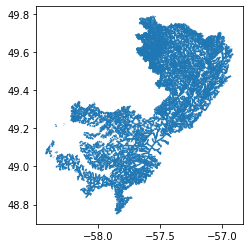

In [8]:
fl_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HN_NLFLOW_1.shp')
fl_df.plot()

# Flatten geo data:
Data from open Canada is 3d, i.e. has a Z component. convert to 2d:

<AxesSubplot:>

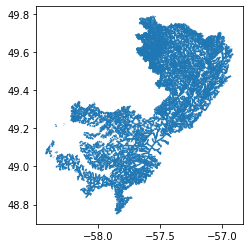

In [9]:
# the data from open canada is 3d meaning it has a Z dimension


def ddd_to_dd_line(g):
    return LineString([xy[0:2] for xy in list(g.coords)]) 

fl_df['geometry'] = fl_df.geometry.apply(lambda x: ddd_to_dd_line(x))
fl_df.plot() 


## Creating segment ID
As the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [10]:
fl_df['row_index'] = fl_df.index
fl_df['row_index'] = fl_df['row_index'].astype('str')
fl_df['segment_id'] = fl_df['DATASETNAM'] + "-" + fl_df.row_index

# Find the closest segment:

In [11]:
# a function for finding the closest point:


def ckdnearesl_line(gdfA, gdfB, gdfB_cols=[], utm_zone = 21):
    """ A is point and B is Linestring
        returns the closest line of gdfB to each point of gdfA and their distance in meters
    """
    gdfA = gdfA.reset_index(drop=True).copy()
    gdfB = gdfB.reset_index(drop=True).copy()
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(np.round(dist,2), name='dist-meters')], axis=1)
    return gdf

In [12]:
# columns to keep from segment dataframe:
fl_cols = ['segment_id'] 

UTM_ZONE = 21
br_fl_nearebr_df = ckdnearesl_line( br_df, fl_df, fl_cols, utm_zone = UTM_ZONE)

<ipython-input-11-a4dad5683543>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [13]:
br_fl_nearebr_df.sort_values('dist-meters')


,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,datasetN_1,planimet_1,complete_1,obstacleTy,obstacle_1,geograph_1,SHAPE_Le_1,geometry,segment_id,dist-meters
93,NaN,None,None,None,None,None,None,None,None,None,...,02YL000,10.0,1.0,1.0,Falls,None,0.000113,POINT (-57.43462 49.49407),02YL000-13111,1.05
96,NaN,None,None,None,None,None,None,None,None,None,...,02YL000,10.0,1.0,1.0,Falls,CGNDB,0.000894,POINT (-57.16960 49.34740),02YL000-25869,1.11
58,NaN,None,Pynn's Brook Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.51766 49.07915),02YL000-27107,1.13
48,NaN,None,Margaret Bowater Park Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.93500 48.94378),02YL000-26901,1.15
41,NaN,None,First Pond Dam (Second Pond Dam),None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-58.00866 48.94687),02YL000-10659,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,NaN,None,Water Supply Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.87177 48.99826),02YL000-13189,120.93
50,NaN,None,Second Pond Dam (Third Pond Dam),None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-58.00301 48.93853),02YL000-11843,144.56
46,NaN,None,Pynn's Brook Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.54935 49.06448),02YL000-27197,1096.76
44,NaN,None,Uncle Arthur Brook Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.45511 49.14651),02YL000-27080,1438.94


Study points are matched with the closest segments to them. Segments are identified by segment_id. The distances between the study locations and the closest segment is stored in the `dist` column.

<AxesSubplot:>

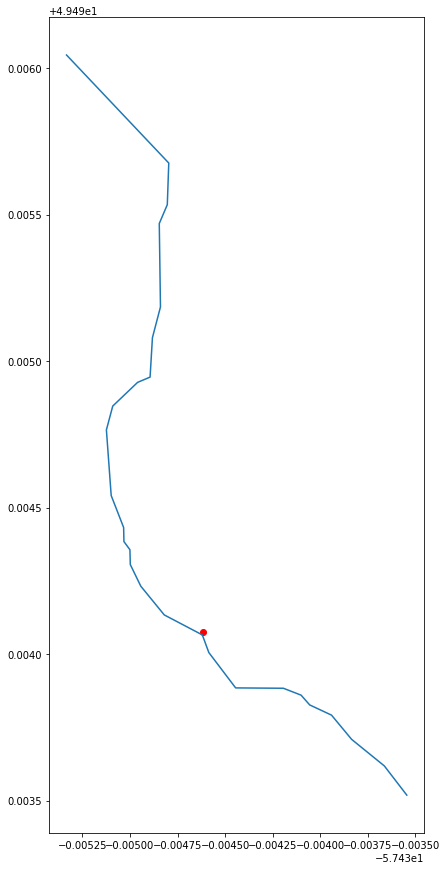

In [14]:
# plot study and segment

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
fl_df[fl_df['segment_id'] == '02YL000-13111'].plot(ax=ax)
br_fl_nearebr_df.iloc[93:94,:].plot(color='red', ax= ax)

## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [15]:
br_fl_nearebr_df['lon'] = br_fl_nearebr_df.geometry.x
br_fl_nearebr_df['lat'] = br_fl_nearebr_df.geometry.y

In [16]:
br_fl_nearebr_df.to_csv('y_barrier_to_segments.csv')

In [12]:
# br_fl_nearebr_df.to_file("study_to_segments.shp")

## Study to water body connection:
Repeat the same process for water bodies dataset.

In [17]:
wb_df = gpd.read_file('data/NHN/NHN_02YL000_3_1_HD_WATERBODY_2.shp')

In [18]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,LAKEID_2,RIVID_1,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09..."
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73..."
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53..."
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54..."
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21..."


## Creating water body ID
Similar to segments, as the ids are not consistent, we use the row number and the DATASETNAME to create an ID for each row.

In [19]:
wb_df['row_index'] = wb_df.index
wb_df['row_index'] = wb_df['row_index'].astype('str')
wb_df['waterbody_id'] = wb_df['DATASETNAM'] + "-" + wb_df.row_index

In [20]:
wb_df.head()

,NID,VALDATE,ACQTECH,DATASETNAM,ACCURACY,PROVIDER,METACOVER,DEFINITION,TYPE_TEXT,ISOLATED,...,RIVID_2,LAKENAME_1,LAKENAME_2,RIVNAME_1,RIVNAME_2,IDDATE,NAMEDATE,geometry,row_index,waterbody_id
0,70a0a6d6d46849318c3764b9830b2f18,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.09482 49.60720 0.00000, -57.09...",0,02YL000-0
1,b0441903adea488d97e258b270722a4e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.73406 49.31636 0.00000, -57.73...",1,02YL000-1
2,85459965150947a99610efd9ca9cb087,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.53319 49.68667 0.00000, -57.53...",2,02YL000-2
3,52b29208f2b04f2fa4e1c7d066f0ae1e,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.54525 49.63484 0.00000, -57.54...",3,02YL000-3
4,8082fbdcaa81437ca046e4d3d5b30c04,1986,5,02YL000,10,2,1,4,Lake,0,...,None,None,None,None,None,None,None,"POLYGON Z ((-57.21786 49.61157 0.00000, -57.21...",4,02YL000-4


In [21]:


def ckdnearesl_poly(gdfA, gdfB, gdfB_cols, utm_zone = 21):
    """ A is point and B is Polygon """
    gdfA = gdfA.reset_index(drop=True)
    gdfB = gdfB.reset_index(drop=True)
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.exterior]

    B = np.array(B)
    A = np.array(A)

    Ashape = A.shape
    
    pp = Proj(proj='utm',zone=utm_zone ,ellps='WGS84', preserve_units=False)

    A = np.array(pp(A[:,0].reshape(-1,1), A[:,1].reshape(-1,1))).transpose().reshape((-1,2))

    A = A.reshape(Ashape)


    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    Bshape = B.shape
    B = np.array(pp(B[:,0].reshape(-1,1), B[:,1].reshape(-1,1))).transpose().reshape(Bshape)


    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)

    idx = itemgetter(*idx)(B_ix) 


    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(np.round(dist,2), name='dist-meters')], axis=1)
    return gdf

<AxesSubplot:>

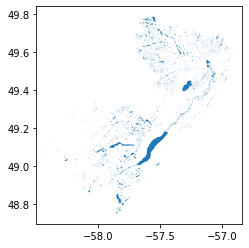

In [22]:
# same as segment, water body data from open canada needs to be 2d

def ddd_to_dd_poly(g):
    return Polygon([xy[0:2] for xy in list(g.exterior.coords)]) 

wb_df['geometry'] = wb_df.geometry.apply(lambda x: ddd_to_dd_poly(x))
wb_df.plot() 


In [23]:
# columns to keep from waterbody dataframe:
wb_cols = ['waterbody_id'] 
br_wb_nearebr_df = ckdnearesl_poly(br_df, wb_df, wb_cols, utm_zone = UTM_ZONE)

<ipython-input-21-967fd8fd78ca>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  B = np.array(B)


In [24]:
br_wb_nearebr_df.sort_values('dist-meters')

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,datasetN_1,planimet_1,complete_1,obstacleTy,obstacle_1,geograph_1,SHAPE_Le_1,geometry,waterbody_id,dist-meters
48,NaN,None,Margaret Bowater Park Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.93500 48.94378),02YL000-7960,1.15
41,NaN,None,First Pond Dam (Second Pond Dam),None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-58.00866 48.94687),02YL000-7719,1.15
3,NaN,None,None,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.81380 48.93042),02YL000-2263,1.15
17,NaN,None,None,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.79708 48.92938),02YL000-2151,1.15
14,NaN,None,None,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-57.93734 48.98522),02YL000-7944,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,NaN,None,None,None,None,None,None,None,None,None,...,02YL000,10.0,1.0,1.0,Falls,None,NaN,POINT (-57.91345 49.26685),02YL000-4200,1645.57
78,NaN,None,None,None,None,None,None,None,None,None,...,02YL000,17.0,1.0,1.0,Falls,None,NaN,POINT (-58.06052 49.10976),02YL000-7820,1732.65
38,NaN,None,Dormody's Brook Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-58.14977 48.98198),02YL000-5376,1871.36
49,NaN,None,Clarke's Brook Dam,None,None,None,None,None,None,None,...,None,NaN,NaN,NaN,None,None,NaN,POINT (-58.14816 48.98126),02YL000-5376,1899.05


## Save in two formats:
- CSV for database import
- gpkg or shp for keeping the geometry feature intact

In [25]:
br_wb_nearebr_df.to_csv('y_barrier_to_waterbody.csv')

In [22]:
# br_wb_nearebr_df.to_file("barrier_to_waterbody.shp")